# User Churn Prediction

In this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
<li>[Part 5: Use Probabilities as Prediction Results](#Part-5:-Use-Probabilities-as-Prediction-Results)
</ul>

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

<ul>
<li>Data Source: https://www.sgi.com/tech/mlc/db/churn.all
<li>Data info: https://www.sgi.com/tech/mlc/db/churn.names
</ul>


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

churn_df = pd.read_csv('data/churn.all')
print churn_df.head()
print churn_df.info()

  state  account_length  area_code phone_number intl_plan voice_mail_plan  \
0    KS             128        415     382-4657        no             yes   
1    OH             107        415     371-7191        no             yes   
2    NJ             137        415     358-1921        no              no   
3    OH              84        408     375-9999       yes              no   
4    OK              75        415     330-6626       yes              no   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             45.07              197.4               99             16.78  

In [2]:
# check if data is inbalanced for classification problem
churn_df.churned.value_counts()

 False.    4293
 True.      707
Name: churned, dtype: int64

In [3]:
# check two related features
print churn_df.state.value_counts()
print churn_df.area_code.value_counts()

WV    158
MN    125
AL    124
ID    119
VA    118
OH    116
TX    116
WY    115
NY    114
OR    114
NJ    112
UT    112
WI    106
ME    103
MA    103
MI    103
MD    102
VT    101
KY     99
KS     99
CT     99
MT     99
MS     99
RI     99
WA     98
IN     98
CO     96
NH     95
DE     94
MO     93
AR     92
NM     91
SC     91
NC     91
FL     90
NV     90
OK     90
AZ     89
TN     89
IL     88
DC     88
NE     88
ND     88
HI     86
SD     85
GA     83
LA     82
PA     77
AK     72
IA     69
CA     52
Name: state, dtype: int64
415    2495
408    1259
510    1246
Name: area_code, dtype: int64


* In quick scan, there is no missing value but data is inbalanced;
* area code is associated with state, but it might be different. This factor only contains three areas probably because data is only collected from the three local stores, which may cause biased sampling;
* phone_number is like userID, except for the case to use phone number to search for speacific person information, in this case it should be ignored
* account length are assumed to the total lenght of the user usage
* people who don't have voice_mail_plan will not have voice mail message  
    % check by churn_df.loc[(churn_df["voice_mail_plan"]=="no") &(churn_df["number_vmail_messages"]!=0)]
* number_customer_service_calls may be a good feature that affect user experience

### Part 1.2: Data cleaning

In [4]:
# plan choice converted to 1,0
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_df[yes_no_cols] = churn_df[yes_no_cols] == ' yes'
churn_df[yes_no_cols] = churn_df[yes_no_cols]*1

# churned converted to 1,0
churn_df["churned"]=churn_df["churned"].map(lambda x: x.strip())

# "phone_number" and "state" are removed
churn_area=churn_df.drop(["phone_number","state"],axis=1)
churn_state=churn_df.drop(["phone_number","area_code"],axis=1)
churn_area.describe().round(2)

,account_length,area_code,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
mean,100.26,436.91,0.09,0.26,7.76,180.29,100.03,30.65,200.64,100.19,17.05,200.39,99.92,9.02,10.26,4.44,2.77,1.57
std,39.69,42.21,0.29,0.44,13.55,53.89,19.83,9.16,50.55,19.83,4.30,50.53,19.96,2.27,2.76,2.46,0.75,1.31
min,1.00,408.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,73.00,408.00,0.00,0.00,0.00,143.70,87.00,24.43,166.38,87.00,14.14,166.90,87.00,7.51,8.50,3.00,2.30,1.00
50%,100.00,415.00,0.00,0.00,0.00,180.10,100.00,30.62,201.00,100.00,17.09,200.40,100.00,9.02,10.30,4.00,2.78,1.00
75%,127.00,415.00,0.00,1.00,17.00,216.20,113.00,36.75,234.10,114.00,19.90,234.70,113.00,10.56,12.00,6.00,3.24,2.00
max,243.00,510.00,1.00,1.00,52.00,351.50,165.00,59.76,363.70,170.00,30.91,395.00,175.00,17.77,20.00,20.00,5.40,9.00


### Part 1.3:  Understand the features

Text(0,0.5,u'counts')

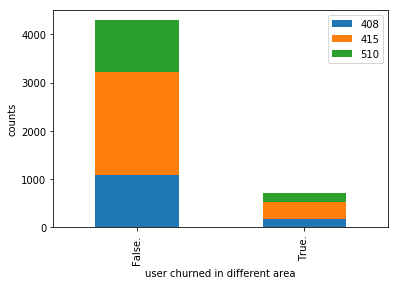

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

churn_415 = churn_area.churned[churn_area.area_code == 415].value_counts()
churn_408 = churn_area.churned[churn_area.area_code == 408].value_counts()
churn_510 = churn_area.churned[churn_area.area_code == 510].value_counts()

df1=pd.DataFrame({u'415':churn_415, u'408':churn_408,
                 u'510':churn_510})
df1.plot.bar(stacked=True)
plt.xlabel(u"user churned in different area") 
plt.ylabel(u"counts") 

Text(0,0.5,u'counts')

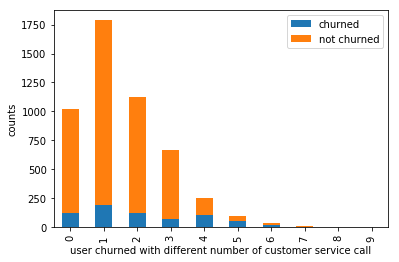

In [6]:
churn_0_cs = churn_area.number_customer_service_calls[churn_area.churned=="False."].value_counts()
churn_1_cs = churn_area.number_customer_service_calls[churn_area.churned=="True."].value_counts()

df2=pd.DataFrame({u'not churned':churn_0_cs, u'churned':churn_1_cs})
df2.plot.bar(stacked=True)
plt.xlabel(u"user churned with different number of customer service call") 
plt.ylabel(u"counts") 

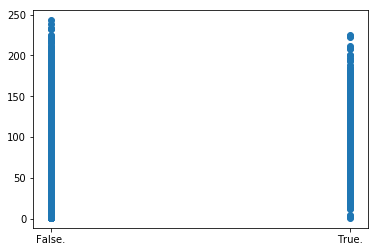

In [7]:
plt.scatter(churn_area.churned, churn_area.account_length)

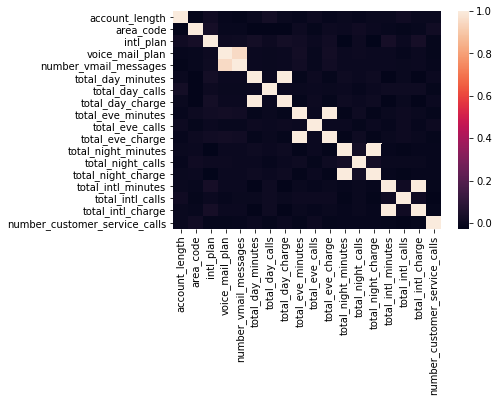

In [8]:
# find the correlation between feature
corr = churn_area.corr()
sb.heatmap(corr)

high correlation:
* voice_mail_plan & number_vmail_messages
* total_day_minutes & total_day_charge
* total_eve_minutes & total_eve_charge
* total_night_minutes & total_night_charge
* total_intl_minutes & total_intl_charge

# Part 2: Feature Preprocessing

In [9]:
# use one-hot-encoding to convert area_code 
churn_area["area_code"]=churn_area["area_code"].map(lambda x: str(x))
churn_feat = churn_area.drop(["churned"], axis=1)
churn_feat=pd.get_dummies(churn_feat)

# convert data into np-array format
y = np.where(churn_df['churned'] == 'True.',1,0)
X = churn_feat.as_matrix().astype(np.float)

In [10]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 5000 observations and 20 features
Unique target labels: [0 1]


# Part 3: Model Training and Result Evaluation

### Part 3.1: K-fold Cross-Validation and Learning Curve

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(n_splits=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred, clf

# NumPy interpretes True and False as 1. and 0.
def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

# plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



### Part 3.2: Run Supervised Learning Models and Calculate Accuracy

Logistic Regression (L2 is default): 0.8648


<module 'matplotlib.pyplot' from '/Users/manxilu/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

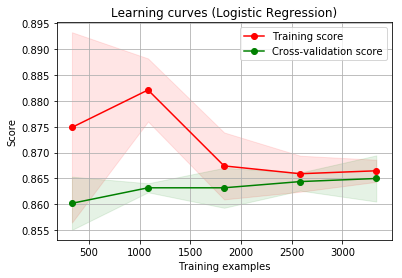

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

LR_CV_result = run_cv(X,y,LogisticRegression)

print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result[0]))
plot_learning_curve(LR_CV_result[1], "Learning curves (Logistic Regression)", X,y)

K-nearest-neighbors: 0.893


<module 'matplotlib.pyplot' from '/Users/manxilu/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

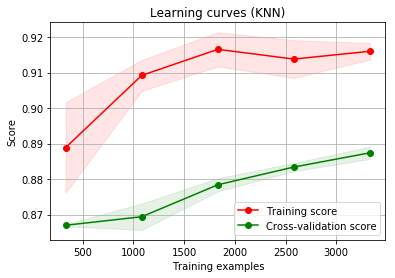

In [13]:
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result[0]))
plot_learning_curve(KNN_CV_result[1], "Learning curves (KNN)", X,y)

Random forest: 0.946


<module 'matplotlib.pyplot' from '/Users/manxilu/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

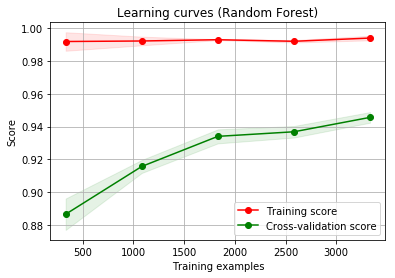

In [14]:
RF_CV_result = run_cv(X,y,RandomForestClassifier)
print "Random forest: " + str(accuracy(y, RF_CV_result[0]))
plot_learning_curve(RF_CV_result[1], "Learning curves (Random Forest)", X,y)

From the learning curve plots and accuracy scores for respective model:
* The model is underfitted in Logistic Regression
* The model is not well-behaved in KNN
* The model is overfitted in Random Forest, we could continuously use this one to furthur tune the hyperprameters

### Part 3.3: Use Grid Search to Find Optimal Parameters

#### Part 3.3.1: Find Optimal Parameters - RandomForest

In [15]:
from sklearn.grid_search import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'n_estimators': [100, 200, 300, 1000]
}

Grid_RF = GridSearchCV(RandomForestClassifier(),param_grid, cv=5, verbose=1, refit=False)
Grid_RF.fit(X, y)
print Grid_RF.best_params_

/Users/manxilu/Applications/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/manxilu/Applications/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'n_estimators': 300, 'bootstrap': True}


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


### Part 3.4: Calculate Confusion Matrix (Precision, Recall, Accuracy)

Random Forest
Accuracy is 0.946
Precision is 0.932673267327
Recall is 0.666195190948


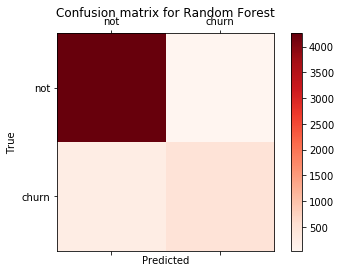

(tn,fp,fn,tp)=  (4259, 34, 236, 471)


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print classifier
    print "Accuracy is " + str(accuracy)
    print "Precision is " + str(precision)
    print "Recall is " + str(recall)

def draw_confusion_matrices(confusion_matricies,class_names=["not","churn"]):
    for cm in confusion_matricies:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

cm=confusion_matrix(y, RF_CV_result[0])
draw_confusion_matrices([("Random Forest", cm)])
print "(tn,fp,fn,tp)= ", (cm[0][0],cm[0][1],cm[1][0],cm[1][1])

# Part 4: Feature Selection

### Random Forest Model - Feature Importance Discussion

In [17]:
importances = RF_CV_result[1].feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat.columns), reverse=True):
    print v + ": " + str(k)

Feature importance ranking by Random Forest Model:
total_day_charge: 0.1852
number_customer_service_calls: 0.1237
total_day_minutes: 0.0997
intl_plan: 0.0708
total_eve_minutes: 0.0683
total_eve_charge: 0.0554
total_intl_calls: 0.0544
total_intl_charge: 0.0426
total_intl_minutes: 0.0421
total_night_minutes: 0.0415
total_night_charge: 0.0377
total_day_calls: 0.035
account_length: 0.0317
total_night_calls: 0.0313
total_eve_calls: 0.0266
voice_mail_plan: 0.0228
number_vmail_messages: 0.0176
area_code_415: 0.006
area_code_510: 0.0044
area_code_408: 0.0032


The corelated features that we are interested in previous heat plot: 
* voice_mail_plan & number_vmail_messages
* total_day_minutes & total_day_charge
* total_eve_minutes & total_eve_charge
* total_night_minutes & total_night_charge
* total_intl_minutes & total_intl_charge

From the above feature importance , the minutes & charge pairs have relative equaly weighting,
and number_vmail_messages has slightly higher weighting than voice_mail_plan.
So we decide to only drop the minutes in the pair and voice_mail_plan in feature data.

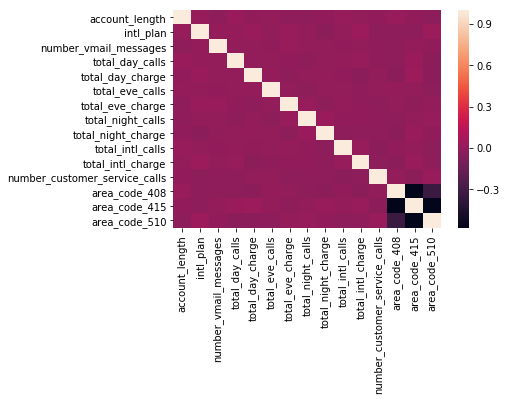

In [46]:
select_df=churn_feat.drop(["total_day_minutes",
                          "total_eve_minutes","total_night_minutes",
                          "total_intl_minutes","voice_mail_plan"],axis=1)
corr_select = select_df.corr()
sb.heatmap(corr_select)

In [47]:
# convert data into np-array format
X_select = select_df.as_matrix().astype(np.float)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_select = scaler.fit_transform(X_select)

RF_select_result = run_cv(X_select,y,RandomForestClassifier)
print "Random forest: " + str(accuracy(y, RF_select_result[0]))

importances_select = RF_select_result[1].feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), select_df.columns), reverse=True):
    print v + ": " + str(k)

Random forest: 0.9358
Feature importance ranking by Random Forest Model:
total_eve_charge: 0.1852
total_day_charge: 0.0997
intl_plan: 0.0708
total_night_calls: 0.0683
total_intl_calls: 0.0554
area_code_510: 0.0544
area_code_415: 0.0421
total_intl_charge: 0.0415
area_code_408: 0.0377
total_eve_calls: 0.035
account_length: 0.0317
number_customer_service_calls: 0.0313
total_night_charge: 0.0266
number_vmail_messages: 0.0228
total_day_calls: 0.0176


* Total_eve_charge has principle weighting and total_day_charge also rank 2rd 
    * Total charge is reasonable feature to affect user churn
    * Contact marketing group to design better plan with affordable charge
* International plan usage has high weighted for user churn
    * Conduct more advertisement on international plan service
    * Improve international telecommunication service (better communication quality, fast internet surffing etc.)
* The people will become more churned from area coded in 510 than that in 415, 408
    * Contact the customer service department from those areas especially in 510 to see if there exists terrible customer service that affect user experience
    * If the service only covered in these three areas, it could a good chance to expand service to other places
* 

# Part 5: Use Probabilities as Prediction Results

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

In [44]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

Result Evaluation: Use the ground truth probability to compare with our probability prediction results.

In [45]:
from collections import defaultdict
true_prob = defaultdict(float)

pred_prob = run_prob_cv(X, y, RandomForestClassifier, n_estimators=200)
pred_churn = pred_prob[:,1]
is_churn = (y == 1)

counts = pd.value_counts(pred_churn)
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

In [ ]:
EvaResults = pd.concat([counts,true_prob], axis=1).reset_index()
EvaResults.columns = ['pred_prob', 'count', 'true_prob']
EvaResults

# Future work

In [ ]:
# plot partial dependency
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor

y_select=pd.DataFrame(y)
clf_for_pplot=GradientBoostingRegressor()

# fit the model as usual
clf_for_pplot.fit(select_feat, y_select)

# Here we make the plot
partial_plots = plot_partial_dependence(clf_for_pplot,       
                                   features=[2, 2,2], # column numbers of plots we want to show
                                   X=select_feat,            # raw predictors data.
                                   feature_names=['area_code_415', 'area_code_408',"area_code_510"], # labels on graphs
                                   grid_resolution=8) # number of values to plot on x axis